In [1]:
#Build a dummy dataset
import numpy as np

# Set random seed for reproducibility
np.random.seed(42)

# Generate the toy dataset
num_samples = 100000
num_variables = 10
num_correlated_variables = 5

# Generate the correlated variables
correlated_variables = 2*(2*np.random.rand(num_samples, num_correlated_variables)-1)

# Generate the uncorrelated variables
uncorrelated_variables = 2*np.random.rand(num_samples, num_variables - num_correlated_variables)-1

# Concatenate the variables
X = np.concatenate((correlated_variables, uncorrelated_variables), axis=1)

# Generate the target classes based on a linear relationship with the correlated variables
weights = np.array([0.2,-0.2,0.2,-0.3,0.3])
bias = 0.0*np.random.randn()
logits = np.dot(correlated_variables, weights) + bias
probabilities = 1 / (1 + np.exp(-logits))
y = np.random.binomial(1, probabilities)

if 0:
  X[y==1,6]+=0.1*np.random.rand(num_samples)

Text(0, 0.5, 'data 4')

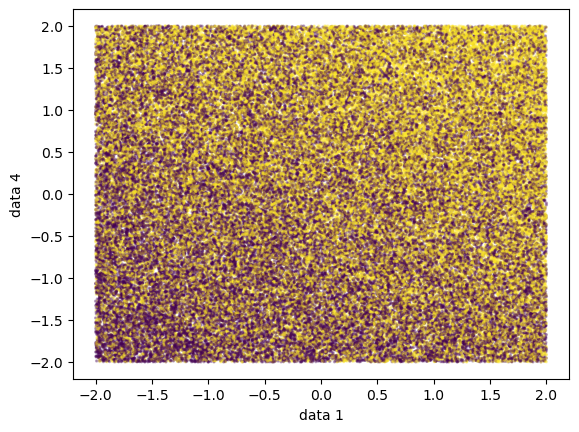

In [2]:
import matplotlib.pyplot as plt
plt.figure()
plt.scatter(X[:,0],X[:,4],c=y,s=2,alpha =0.3)
plt.xlabel("data 1")
plt.ylabel("data 4")

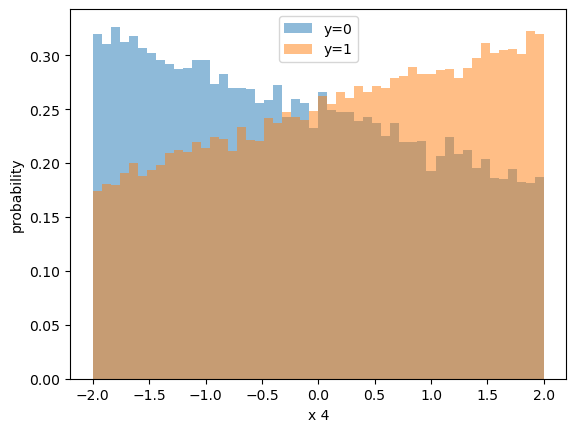

In [3]:
plt.figure()
plt.hist(X[y==0,4],50,alpha =0.5,density=True,label="y=0")
plt.hist(X[y==1,4],50,alpha =0.5,density=True,label="y=1")
plt.xlabel("x 4")
plt.ylabel("probability")
plt.legend()

In [4]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

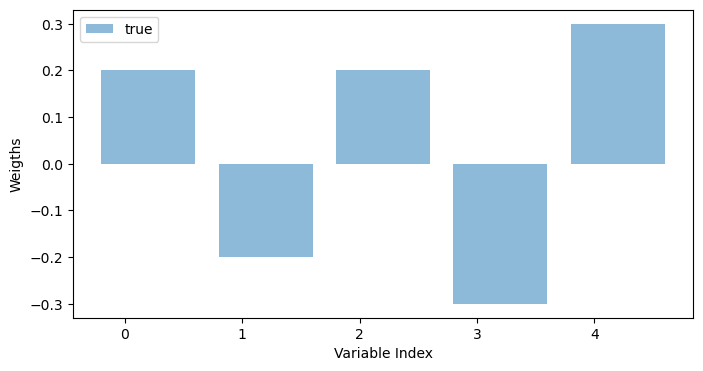

In [5]:
plt.figure(figsize=(8, 4))
plt.bar(np.arange(5)+0.2, weights, alpha=0.5, label="true")
plt.xlabel("Variable Index")
plt.ylabel("Weigths")
plt.legend()

In [6]:
import torch
import torch.nn as nn
import torch.optim as optim

X_tensor = torch.from_numpy(X_train).float()
y_tensor = torch.from_numpy(y_train).float()

In [8]:
# from sklearn import logisticRegression

class LogisticRegression(nn.Module):
    def __init__(self, input_size, lambdaL1=0.001, n_iter = 150):
        super(LogisticRegression, self).__init__()
        self.n_iter = n_iter
        # definizione dei pesi
        self.linear = nn.Linear(input_size, 1) # trasf. lineare; costruttore oggetto "linear"; linear(data)
        self.sigmoid = nn.Sigmoid()
        self.lambdaL1 = lambdaL1

    def forward(self, x):
        out = self.linear(x)
        out = self.sigmoid(out)

        return out

    def predict(self, numpy_in):
        pred = self(torch.from_numpy(numpy_in).float()).detach().numpy().squeeze() >= 0.5

        return pred
        
    def L1penality(self):
        # termine da aggiungere alla loss (iperpar. lambda)
        return  self.lambdaL1 * self.linear.weight.abs().sum()

    def fit(self, X, Y):
        losses = []
        accuracies = []
        criterion = nn.BCELoss() # funzione loss da derivare
        optimizer = optim.SGD(self.parameters(), lr=0.1) # step di ottimiz. dei pesi che dipende dalla derivata della
        for epoch in range(self.n_iter):

            # forward
            outputs = self(X)
            loss = criterion(outputs.squeeze(), Y) + self.L1penality()
            #print(loss)

            # backward
            optimizer.zero_grad() # resetta il gradiente
            loss.backward() # questa è la derivata
            optimizer.step()

            # calcolo accuracy
            predicted_labels = (outputs >= 0.5).float().squeeze()
            accuracy = (predicted_labels == Y).float().mean()
            #print("acc:",accuracy)
            #print(model.linear.weight.detach().numpy()) # i pesi si aggiornano ad ogni step

            losses.append(loss.item())
            accuracies.append(accuracy.item())
            #break
        return accuracies, losses

l:  1
l:  0.7
l:  0.5
l:  0.1
l:  0.05
l:  0.01
l:  0.005
l:  0.001


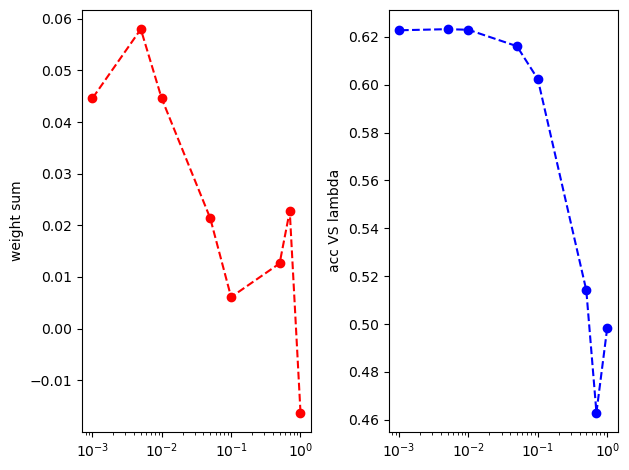

In [9]:
# proviamo il modello

input_size = X.shape[1] # numero di features

lambdavec = [1,0.7,0.5,0.1,0.05,0.01,0.005,0.001]
weightsum = []
accVSlambda =[]

for l in lambdavec:
    model = LogisticRegression(input_size, lambdaL1 = l)
    accuracies, losses = model.fit(X_tensor, y_tensor)
    # accuracy migliore mantenendo bassa la somma dei pesi superflui
    pred_weights = model.linear.weight.detach().numpy().squeeze()[4:].mean()
    weightsum.append(pred_weights)
    accVSlambda.append(accuracies[-1])
    print("l: ", l)

#dummy_out = model(X_tensor) # è un modulo pytorch -> l'input deve essere un tensore

#plt.hist(dummy_out.detach().numpy(), bins = 200) # detach rimuove le funzione applicate al tensore
#plt.show()

plt.figure()
plt.subplot(121)
plt.plot(lambdavec, weightsum, '--or')
plt.xscale("log")
plt.ylabel('weight sum')
plt.subplot(122)
plt.plot(lambdavec, accVSlambda, '--ob')
plt.ylabel('acc VS lambda')
plt.xscale("log")
plt.tight_layout()
plt.show()

<Axes: >

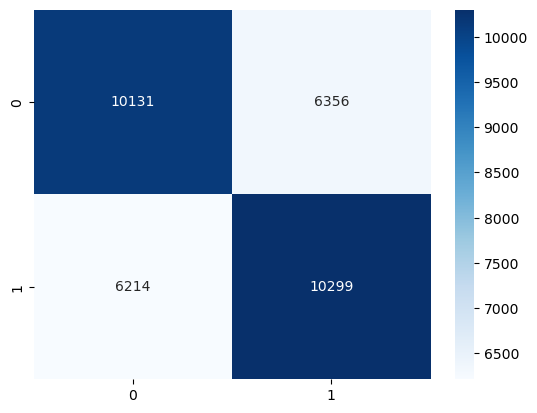

In [10]:
# evaluation --> sklearn predict
y_pred = model.predict(X_test)

# confusion matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns
confusion_mat = confusion_matrix(y_test, y_pred)

sns.heatmap(confusion_mat, annot=True, fmt="d", cmap="Blues")

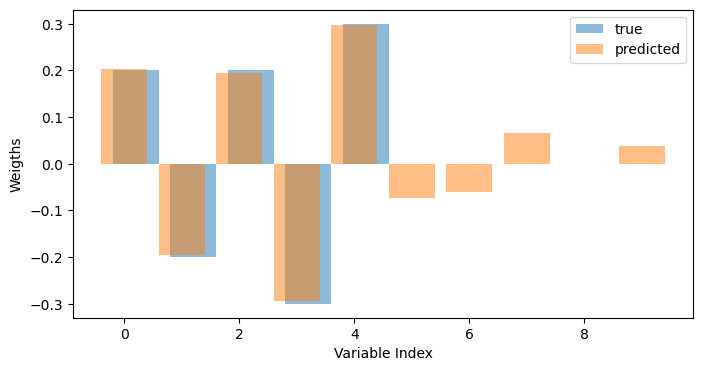

In [11]:
pred_weights = model.linear.weight.detach().numpy().squeeze()
plt.figure(figsize=(8, 4))
plt.bar(np.arange(5)+0.2, weights, alpha=0.5, label="true")
plt.bar(np.arange(10), pred_weights, alpha=0.5, label="predicted")
plt.xlabel("Variable Index")
plt.ylabel("Weigths")
plt.legend()